In [2]:
import numpy as np
import pulser
from pprint import pprint
from pulser import Pulse, Sequence, Register

### 1. Creating the  `Register`

The `Register` defines the positions of the atoms and their names of each one. There are multiple ways of defining creating a `Register`, the most customizable one being to create a dictionary that associates a name (the key) to a cooordinate (the value).

In [3]:
#Place qubits on a square lattice (L qubit on each side)

#insert the value of L
L = 5

#create a square lattice
square = np.array([[i, j] for i in range(L) for j in range(L)], dtype=float)

#displace the lattice 
square -= np.mean(square, axis=0)

#increase the size of the lattice  5 times
square *= 5

#define  Register
qubits = dict(enumerate(square)) 

reg = Register(qubits)


The `Register` class provides some useful features, like the ability to visualise the array and to rotate it.

Qubits register:


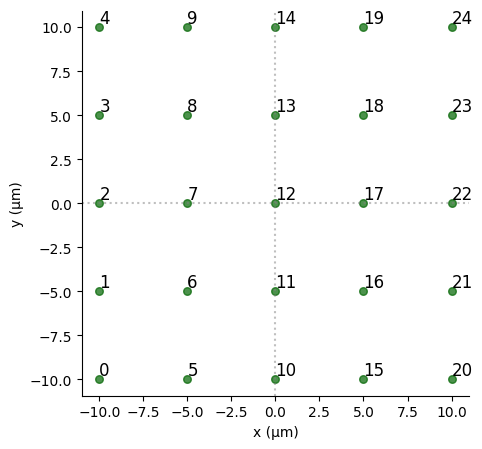

In [4]:
# Make a copy of  reg1, in order not to change reg
reg1 = Register(qubits)  
#Draw register
print("Qubits register:")
reg1.draw()

Rotated register :


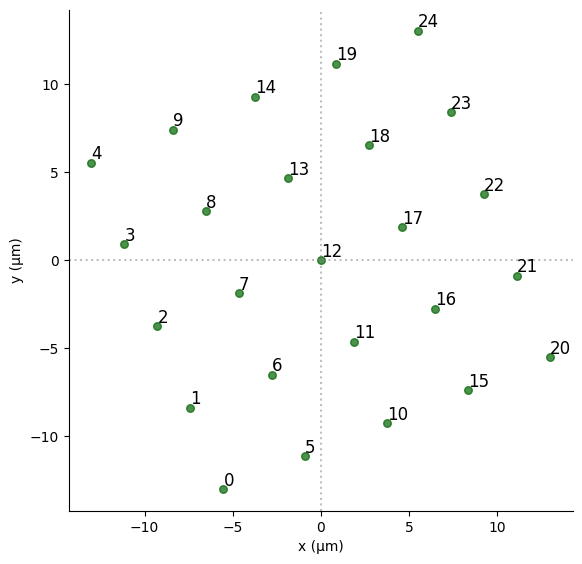

In [5]:
# Rotate by 45 degrees
reg1.rotate(22)   
#Draw register
print("Rotated register :")
reg1.draw()

If one doesn't particularly care about the name given to the qubits, one can also create a `Register` just from a list of coordinates (using the `Register.from_coordinates` class method). In this case, the qubit ID's are just numbered, starting from 0, in the order they are provided in, with the option of adding a common prefix before each number. Also, it automatically centers the entire array around the origin, an option that can be disabled if desired.


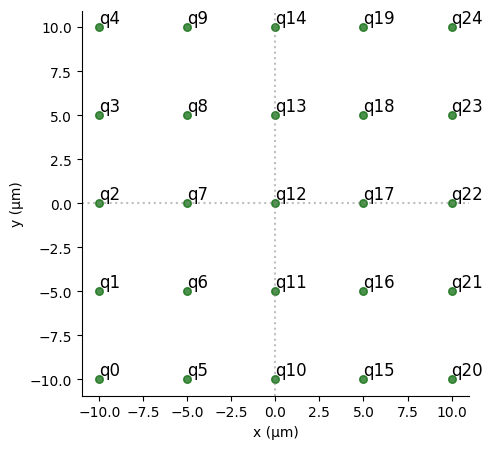

In [6]:
# qubit IDs start with a 'q'
reg2 = Register.from_coordinates(square, prefix='q')   
reg2.draw()


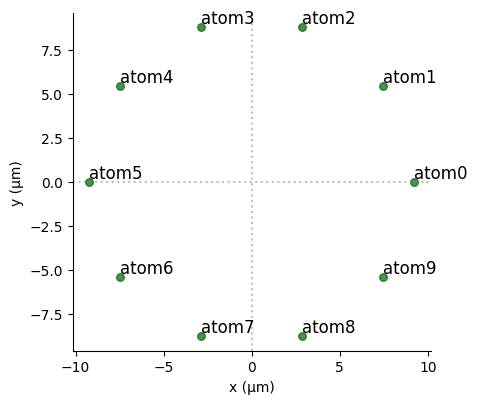

In [7]:
#Place atoms ona ring in such a way that atoms are at distance 5 micrometers

# L is the number of atoms
L=10

# distance between  atoms
R_interatomic=6
coords = R_interatomic/(2*np.tan(np.pi/L)) * np.array([(np.cos(theta*2*np.pi/L), np.sin(theta*2*np.pi/L)) for theta in range(L)])

#register of qubits
reg3 = Register.from_coordinates(coords, prefix='atom')
reg3.draw()

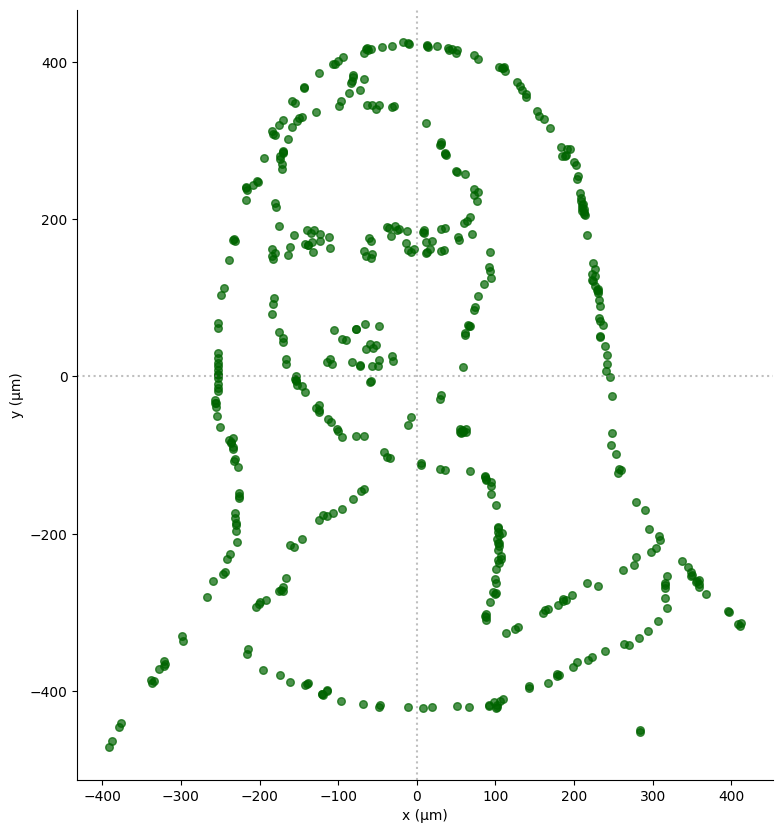

In [8]:
# Place atoms like in the file file ml_coords
qubits = np.loadtxt("files/ml_coords.txt")
ml_reg = Register.from_coordinates(qubits)
ml_reg.rotate(90)
ml_reg.draw(with_labels=False)

### 2.  Initializing the Sequence

To create a `Sequence`, one has to provide it with the `Register` instance and the device in which the sequence will be executed. The chosen device will dicate whether the register is valid or not.

We import the device (in this case, `Chadoq2`) from `pulser.devices` and initialize our sequence with the freshly created register:

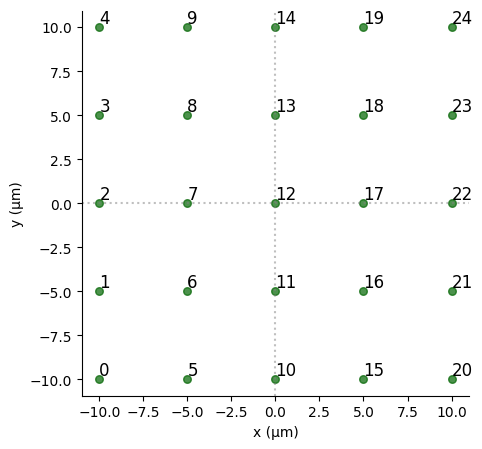

In [10]:
from pulser.devices import Chadoq2
# from pulser.devices import MockDevice

#draw register
reg.draw()

#Initialize sequence
seq = Sequence(reg, Chadoq2)

### 3. Declaring the channels (laser) that will be used

Inspecting what channels are available on this device:

In [11]:
print("Available channels:")
print(seq.available_channels.keys())
print()
print("Properties of available channels:\n")
print(seq.available_channels['rydberg_global'],"\n")
print(seq.available_channels['rydberg_local'],"\n")
print(seq.available_channels['raman_local'],"\n")


Available channels:
dict_keys(['rydberg_global', 'rydberg_local', 'raman_local'])

Properties of available channels:

Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 15.707963267948966 rad/µs, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg') 

Rydberg.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Minimum retarget time: 220 ns, Fixed retarget time: 0 ns, Max targets: 1, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg') 

Raman.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Minimum retarget time: 220 ns, Fixed retarget time: 0 ns, Max targets: 1, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'digital') 



Use channels `'rydberg_local'` ,  `'raman_local'` e `'rydberg_global'`. Note how a declared channel is no longer reported as available.

In [12]:
#Declare channel I want to use

seq.declare_channel('ch0', 'raman_local')
print("Available channels after declaring 'ch0':")
pprint(seq.available_channels.keys())

seq.declare_channel('ch1', 'rydberg_local', initial_target=4)
print("\nAvailable channels after declaring 'ch1':")
pprint(seq.available_channels.keys())

seq.declare_channel('ch2', 'rydberg_global')
print("\nAvailable channels after declaring 'ch2':")
pprint(seq.available_channels.keys())

Available channels after declaring 'ch0':
dict_keys(['rydberg_global', 'rydberg_local'])

Available channels after declaring 'ch1':
dict_keys(['rydberg_global'])

Available channels after declaring 'ch2':
dict_keys([])


At any time, we can also consult which channels were declared, their specifications and the name they were given by calling:

In [13]:
#To check which channels I declared
seq.declared_channels

{'ch0': Raman.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Minimum retarget time: 220 ns, Fixed retarget time: 0 ns, Max targets: 1, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'digital'),
 'ch1': Rydberg.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Minimum retarget time: 220 ns, Fixed retarget time: 0 ns, Max targets: 1, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg'),
 'ch2': Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 15.707963267948966 rad/µs, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg')}

### 4. Composing a Sequence

Every channel needs to start with a target. For `Global` channels this is predefined to be all qubits in the device, but for `Local` channels this has to be defined. This initial target can be set through at channel declaration (see how `'ch1'` was set to target qubit `4`), or it can be done through the standard `target` instruction.

In [14]:
seq.target(1, 'ch0')

Now both channels have an initial target, so we can start building the sequence. Let's start by creating a simple pulse with a constant Rabi frequency of 2 MHz and a constant detuning of -10 MHz that lasts 200 ns.

In [15]:
#Create a simple pulse with amplitude A=2MHz,  detuning 𝛿=-10MHz and a time of t=200ns (Phase  ϕ is zero)

simple_pulse = Pulse.ConstantPulse(200, 2, -10, 0)

Add this pulse to `'ch0'`:

In [17]:
seq.add(simple_pulse, 'ch0')

Now, say we want to deactivate `'ch1'` for 100 ns while `'ch0'` is doing its pulse. We do that by calling: 


In [18]:
seq.delay(100, 'ch1')

Next, we want to create a more complex pulse to add to `'ch1'`, where the amplitude and the detuning are not constant. To do that, we use `Waveform`s:

In [19]:
from pulser.waveforms import RampWaveform, BlackmanWaveform

#Define duration of pulse
duration = 1000

#Define amplitude of pulse
amp_wf = BlackmanWaveform(duration, np.pi/2)   # Durata: 1000 ns, Area: pi/2

#Define detuning of pulse
detuning_wf = RampWaveform(duration, -20, 20)  # Durata: 1000 ns, rampa lineare da  -20 to 20 MHz

We can visualize a waveform by calling:

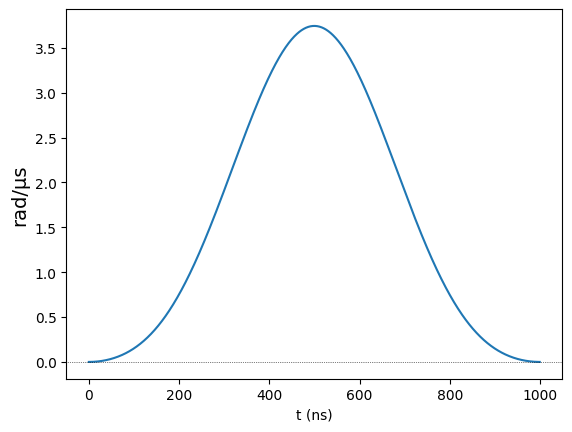

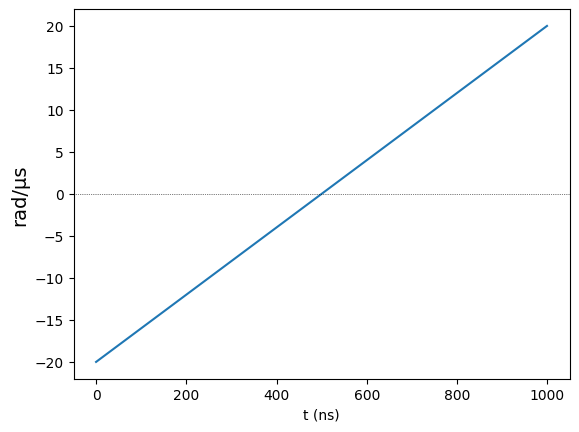

In [20]:
#We can visualize a waveform
amp_wf.draw()
detuning_wf.draw()

Also, it is often convenient to find the integral of a waveform, which can be obtain by calling:

In [22]:
amp_wf.integral   # dimensionless

1.5707963267948968

We then create the pulse with the waveforms instead of fixed values and we can also visualize it:

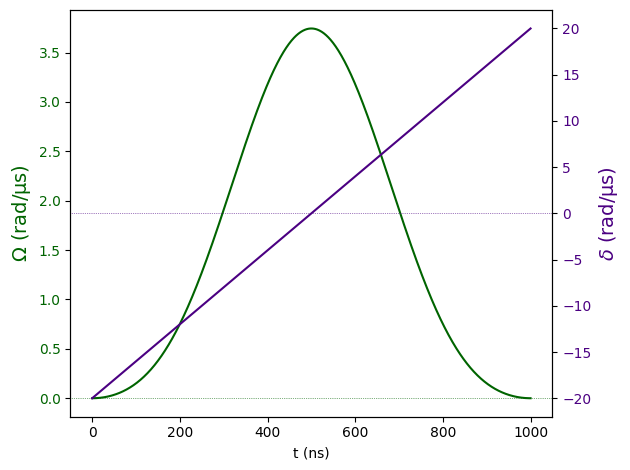

In [21]:
complex_pulse = Pulse(amp_wf, detuning_wf, phase=0)
complex_pulse.draw()

When we're satisfied, we can then add it to a channel:

In [22]:
seq.add(complex_pulse, 'ch1')

Let's check the schedule to see how this is looking:

In [23]:
print(seq)

Channel: ch0
t: 0 | Initial targets: 1 | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 1
t: 200->400 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 1

Channel: ch1
t: 0 | Initial targets: 4 | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->1100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: 4

Channel: ch2
t: 0 | Initial targets: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24 | Phase Reference: 0.0 




Visualize the sequence 

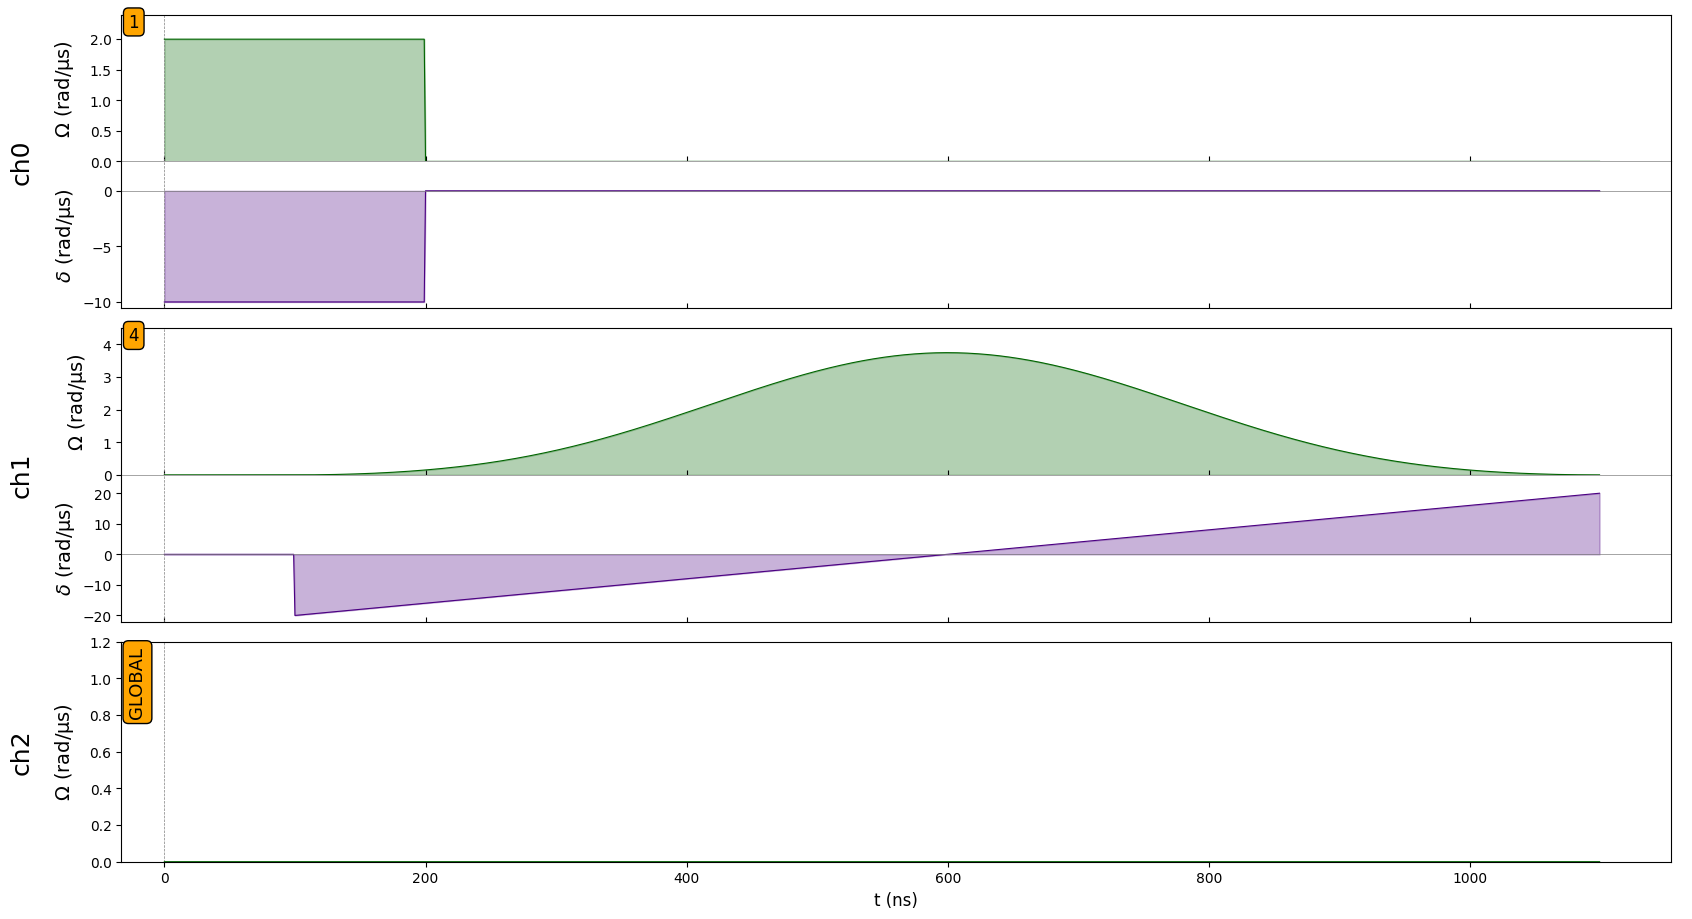

In [26]:
seq.draw()

Now, let's see how the Sequence builder handles conflicts (i.e. two channels acting on the same qubit at once). We're going to add a `complex_pulse`to `'ch0'`, but now we want to target it to qubit `4`, which is the same target of `'ch1'`.

Current Schedule:
Channel: ch0
t: 0 | Initial targets: 1 | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 1
t: 200->400 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 1
t: 400->400 | Target: 4 | Phase Reference: 0.0
t: 400->1100 | Delay 
t: 1100->2100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: 4

Channel: ch1
t: 0 | Initial targets: 4 | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->1100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: 4

Channel: ch2
t: 0 | Initial targets: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24 | Phase Reference: 0.0 




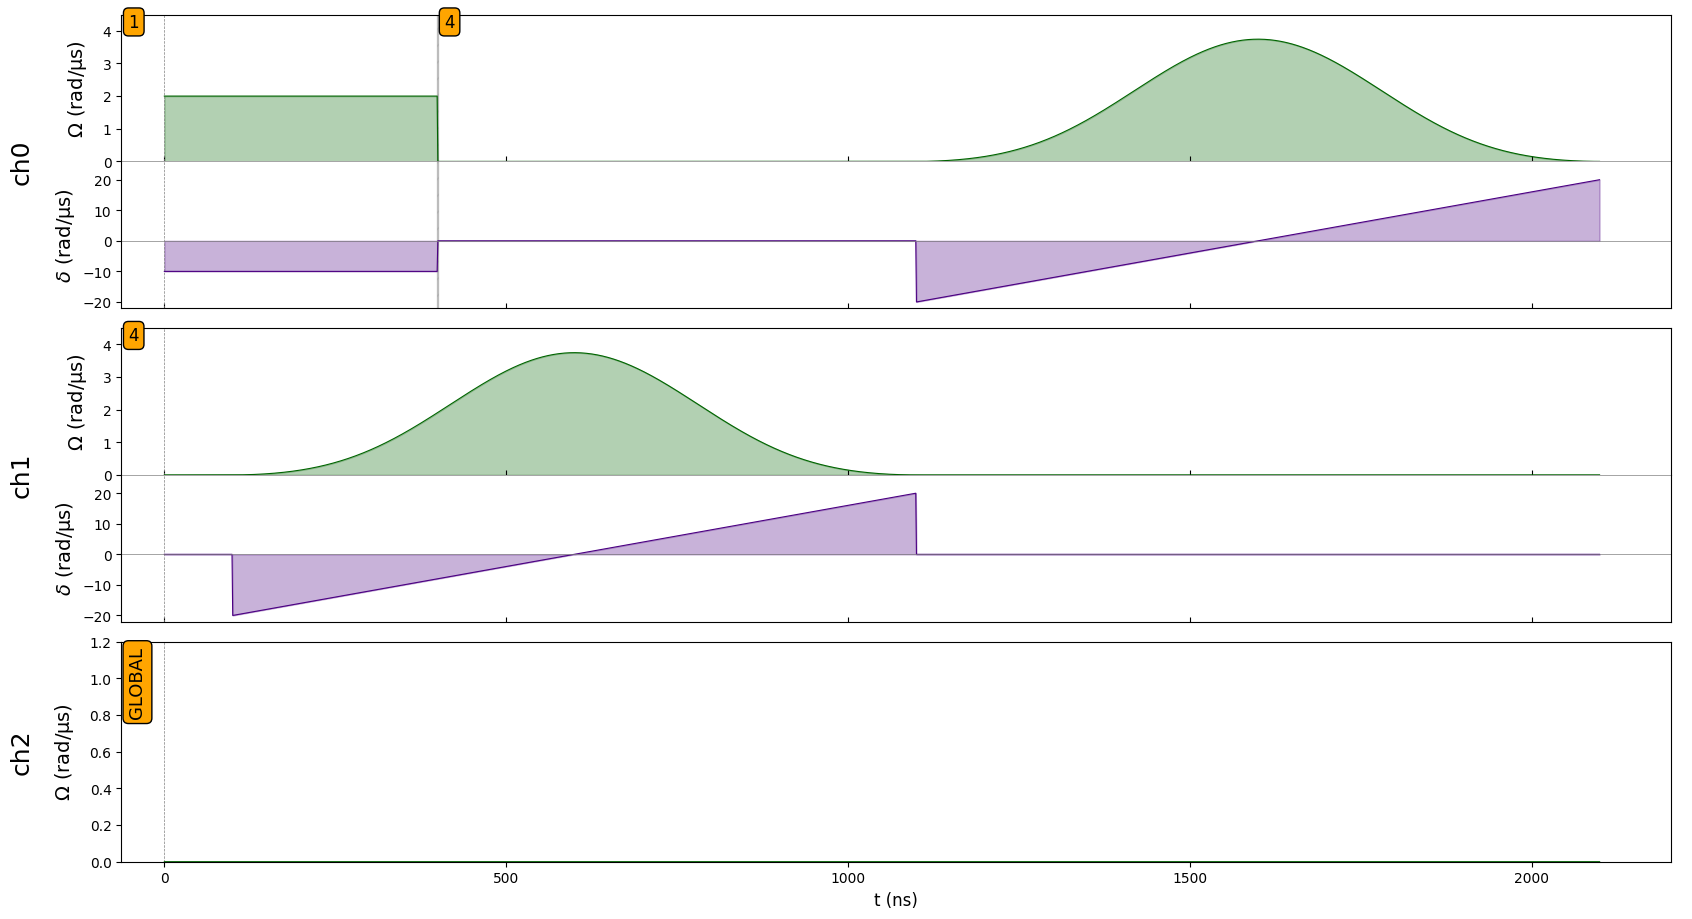

In [24]:
seq.target(4, 'ch0')
seq.add(complex_pulse, 'ch0')

print("Current Schedule:")
print(seq)
seq.draw()

By looking at the current schedule, we can see that `'ch0'` was delayed from `ti=220` to `tf=1100`, and only then was the `complex_pulse` added. The reason for this is simple: it had to wait for the pulse on `ch1`, also targeted to qubit `4`, to finish before it could apply its own. It behaved this way because, in `Sequence.add` there is a default argument `protocol='min-delay`.

Another protocol for pulse addition is `wait-for-all`, which makes the new pulse wait even if there is no conflict. Let's remove the conflict and add two `simple_pulse`s to `ch1` with the different protocols to see how the compare.

Current Schedule:
Channel: ch0
t: 0 | Initial targets: 1 | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 1
t: 200->220 | Target: 4 | Phase Reference: 0.0
t: 220->1100 | Delay 
t: 1100->2100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: 4

Channel: ch1
t: 0 | Initial targets: 4 | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->1100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: 4
t: 1100->1100 | Target: 0 | Phase Reference: 0.0
t: 1100->1300 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 0
t: 1300->2100 | Delay 
t: 2100->2300 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 0

Channel: ch2
t: 0 | Initial targets: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24 | Phase Reference: 0.0 




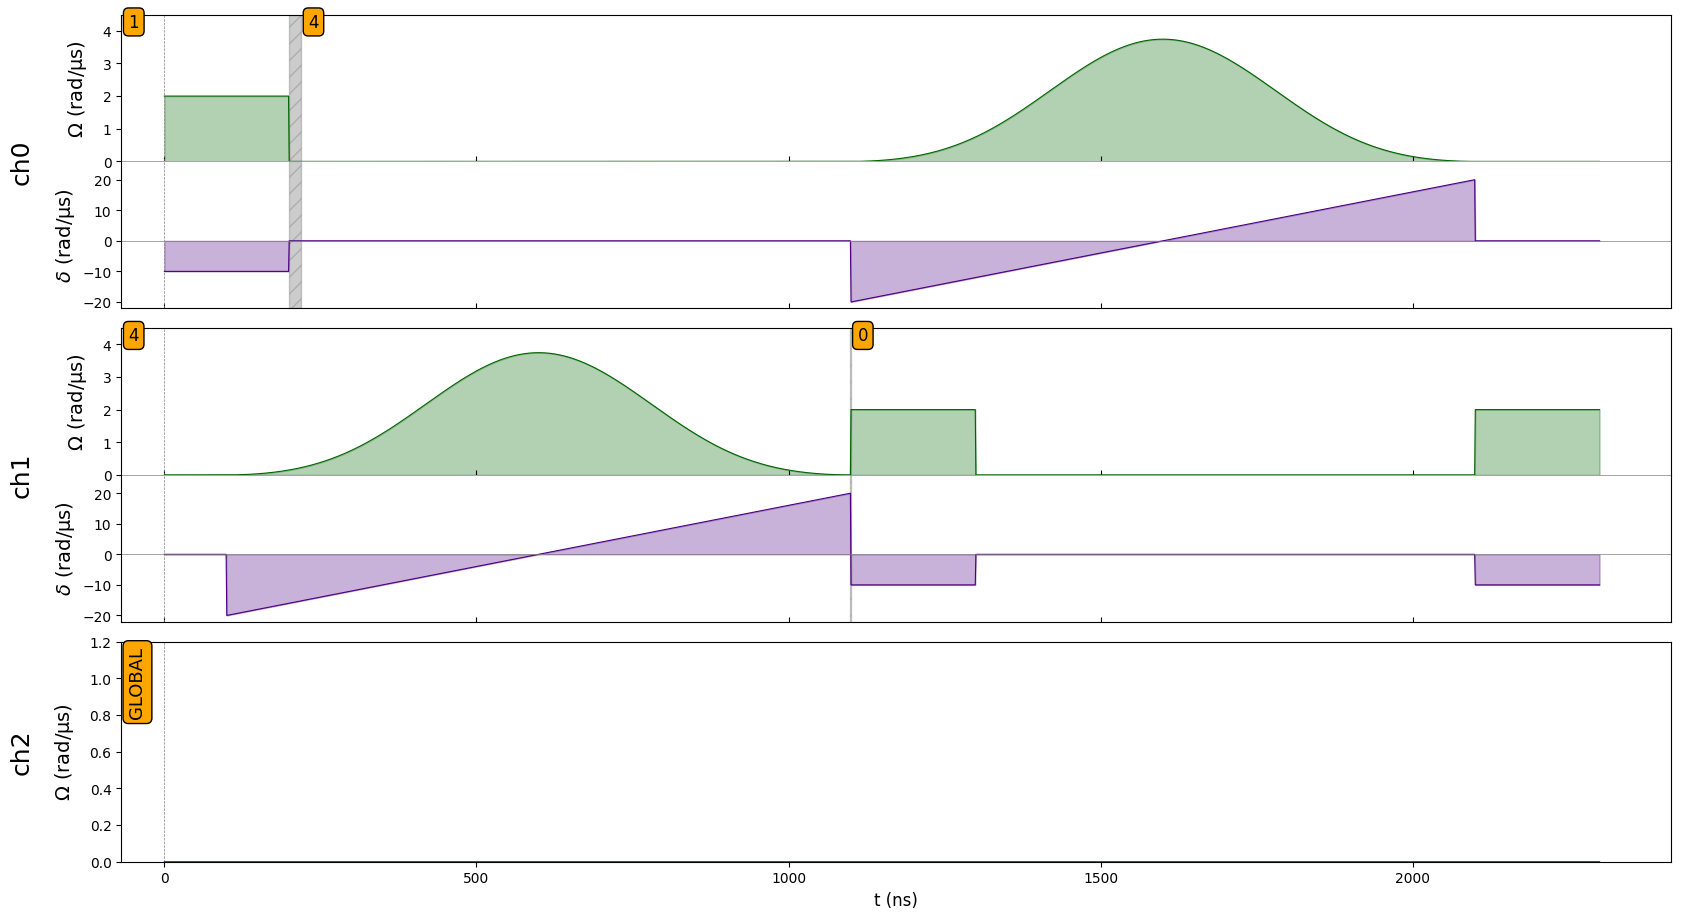

In [28]:
seq.target(0, 'ch1')
seq.add(simple_pulse, 'ch1', protocol='min-delay')
seq.add(simple_pulse, 'ch1', protocol='wait-for-all')

print("Current Schedule:")
print(seq)
seq.draw()

The third protocol is called `'no-delay'` which, as the name implies, never delays the channel where the pulse is being added, even if that means introducing a conflict.

Current Schedule:
Channel: ch0
t: 0 | Initial targets: 1 | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 1
t: 200->220 | Target: 4 | Phase Reference: 0.0
t: 220->1100 | Delay 
t: 1100->2100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: 4
t: 2100->2100 | Target: 0 | Phase Reference: 0.0
t: 2100->3100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: 0

Channel: ch1
t: 0 | Initial targets: 4 | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->1100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: 4
t: 1100->1100 | Target: 0 | Phase Reference: 0.0
t: 1100->1300 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 0
t: 1300->2100 | Delay 
t: 2100->2300 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: 0

Channel: ch2
t: 0 | Initial targets: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,

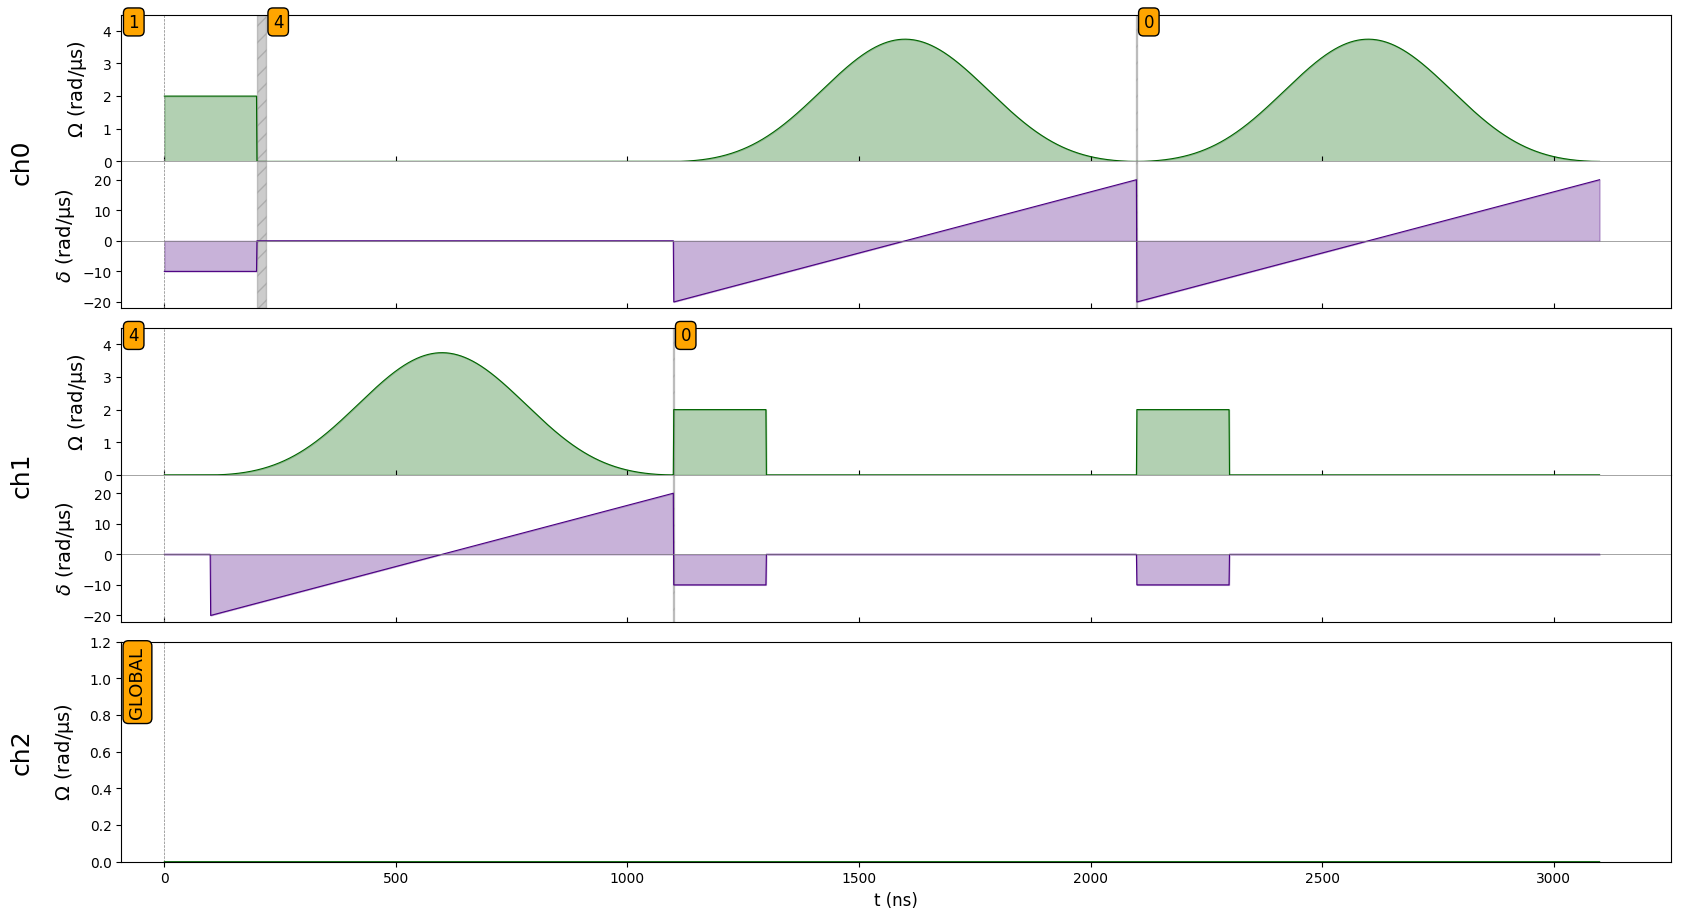

In [29]:
seq.target(0, 'ch0')
seq.add(complex_pulse, 'ch0', protocol='no-delay')

print("Current Schedule:")
print(seq)
seq.draw()

#### 5. Measurement

To finish a sequence, we measure it. A measurement signals the end of a sequence, so after it no more changes are possible. We can measure a sequence by calling:

In [30]:
seq.measure(basis='ground-rydberg')

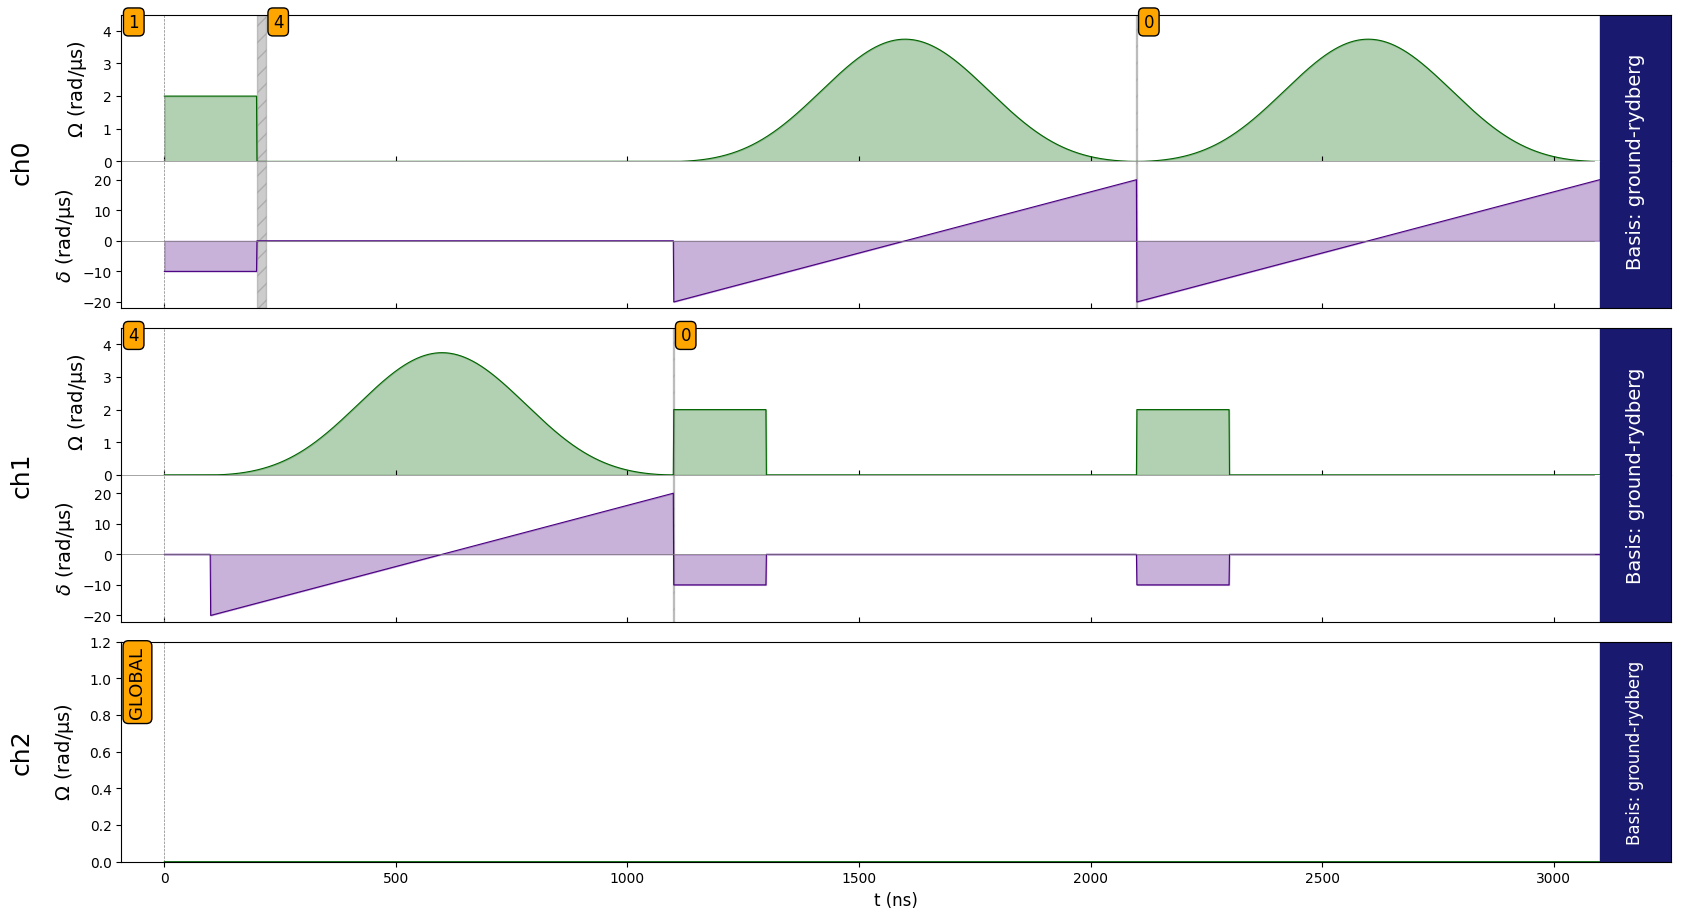

In [31]:
seq.draw()